In [3]:
import numpy as np
import pandas as pd
import re
import string
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
from matplotlib import colors

%config InlineBackend.figure_format = 'retina'
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [4]:
dat = pd.read_json("JEOPARDY_QUESTIONS1.json")
dat["air_date"] = pd.to_datetime(dat["air_date"])
dat["air_year"] = dat["air_date"].dt.year
round2idx = {cat: idx for idx, cat in enumerate(np.unique(dat['round'].values))}
dat["round"] = dat["round"].map(round2idx)
round2idx


{'Double Jeopardy!': 0, 'Final Jeopardy!': 1, 'Jeopardy!': 2, 'Tiebreaker': 3}

# Data

The json file is an unordered list of questions where each question has

- 'category' : the question category, e.g. "HISTORY"
- 'value' : $ value of the question as string, e.g. "$200"
- 'question' : text of question
- 'answer' : text of answer
- 'round' : one of "Jeopardy!","Double Jeopardy!","Final Jeopardy!" or "Tiebreaker"
- 'show_number' : string of show number, e.g '4680'
- 'air_date' : the show air date in format YYYY-MM-DD

In [5]:
dat.head(10)

,category,air_date,question,value,answer,round,show_number,air_year
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,2,4680,2004
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,2,4680,2004
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,$200,Arizona,2,4680,2004
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",$200,McDonald\'s,2,4680,2004
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",$200,John Adams,2,4680,2004
5,3-LETTER WORDS,2004-12-31,"'In the title of an Aesop fable, this insect s...",$200,the ant,2,4680,2004
6,HISTORY,2004-12-31,'Built in 312 B.C. to link Rome & the South of...,$400,the Appian Way,2,4680,2004
7,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 8: 30 steals for the Birmingham Barons; 2...,$400,Michael Jordan,2,4680,2004
8,EVERYBODY TALKS ABOUT IT...,2004-12-31,"'In the winter of 1971-72, a record 1,122 inch...",$400,Washington,2,4680,2004
9,THE COMPANY LINE,2004-12-31,'This housewares store was named for the packa...,$400,Crate & Barrel,2,4680,2004


We have 27995 different categories of topic, that's a insanely number, and we hope use LDA topic modeling to get a general sense what're the topics of jeapardy, and how the topics goes along with the time trend.

In [6]:
category = dat["category"].value_counts().index
cat_distribution = dat["category"].value_counts()
len(category)

27995

# Preprocessing

In [7]:
dat = pd.read_json("JEOPARDY_QUESTIONS1.json")
dat["air_date"] = pd.to_datetime(dat["air_date"])
dat["air_year"] = dat["air_date"].dt.year
round2idx = {cat: idx for idx, cat in enumerate(np.unique(dat['round'].values))}
dat["round"] = dat["round"].map(round2idx)

In [267]:
ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves", "just"])

In [268]:
def normalize(text):
    """
    Given a string, return a list of words normalized as follows.
    Split the string to make words first by using regex compile() function
    and string.punctuation + '0-9\\r\\t\\n]' to replace all those
    char with a space character.
    Split on space to get word list.
    Ignore words < 3 char long.
    Lowercase all words
    """
    pattern = r'\({0,1}<a.*?</a>?\){0,1}'
    text = re.sub(pattern, "", text).strip()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)  # delete stuff but leave at least a space to avoid clumping together
    words = nopunct.split(" ")
    words = [w for w in words if len(w) > 2]  # ignore a, an, to, at, be, ...
    words = [w.lower() for w in words if w not in ENGLISH_STOP_WORDS]
    txt = " ".join(words)
    # sentence = " ".join([ent.text for ent in nlp(txt) if ent.pos_ in ['PROPN','NOUN']])
    return txt

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [8]:
dat_1984 = dat.copy()
dat_1984_list = dat_1984["question"] = dat_1984["question"].apply(normalize)
# dat_1984_list = dat_1984["question"] = dat_1984["question"].apply(lemmatization)

# Modeling

In [9]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(dat_1984_list)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf = tf_vectorizer.fit_transform(dat_1984_list)
tf_feature_names = tf_vectorizer.get_feature_names()

# Define number of topics

After do some reserach and hyprerparamter tuning, we decided 10 is a desired number of topic

In [ ]:
# from sklearn.model_selection import GridSearchCV
# lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
#                                       max_iter=10,               # Max learning iterations
#                                       learning_method='online',   
#                                       random_state=100,          # Random state
#                                       batch_size=128,            # n docs in each learning iter
#                                       evaluate_every = -1,       # compute perplexity every n iters, default: Don't
#                                       n_jobs = -1,               # Use all available CPUs
#                                      )
# lda_output = lda_model.fit_transform(tf)
# search_params = {'n_components': [10, 15, 20, 25, 30, 40, 50, 60, 70], 'learning_decay': [.5, .7, .9]}
# lda = LatentDirichletAllocation()
# model = GridSearchCV(lda, param_grid=search_params)

# # Do the Grid Search
# model.fit(tf)
# model.best_params_

In [10]:
no_topics = 10

# Run NMF
# nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

# Define the Topic theme

One of the biggest difficult part of topic modeling is we need some human decisions to determine the number of topics and more importantly the content of each topic.

In [11]:
# Show top n keywords for each topic
def show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [12]:
topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=20)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,city,called,term,famous,book,home,named,woman,character,house,big,like,know,head,major,nation,early,night,dog,didn
Topic 1,country,known,american,said,king,river,south,north,america,popular,west,miles,person,general,george,james,leader,form,came,heard
Topic 2,title,used,john,great,star,national,movie,sea,water,british,school,second,university,german,named,feet,law,girl,married,point
Topic 3,film,type,novel,make,century,work,says,set,based,place,god,took,gave,museum,town,oscar,created,area,actor,nickname
Topic 4,word,played,time,letter,group,got,greek,comes,latin,founded,meaning,father,went,end,william,near,large,animal,henry,introduced
Topic 5,day,hit,long,love,red,musical,story,men,short,singer,young,did,african,spanish,opera,left,come,party,blue,band
Topic 6,seen,years,year,capital,won,war,old,people,life,white,man,body,later,black,classic,wife,high,team,world,queen
Topic 7,man,world,song,largest,don,little,series,good,best,use,times,rock,park,built,earth,california,using,street,tree,record
Topic 8,state,like,president,born,play,line,number,english,died,son,music,bird,england,lake,battle,days,july,role,washington,court
Topic 9,new,wrote,french,means,company,author,island,game,family,way,york,include,small,death,published,right,mother,history,boy,car


In [ ]:
# {
#     0: "",
#     1: "history_leader_country"
#     2: "college_school"
#     3: "film_media"
#     4: "something1"
#     5: "music_opera_song",
#     6: "war_people"


# }

# Topic Distribution for each doc

In [236]:
# Create Document — Topic Matrix
lda_output = lda.transform(tf)
# column names
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(dat_1984_list))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic["round"] = dat["round"].values


# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)


# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
# df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,round
Doc0,0.220000,0.020000,0.020000,0.020000,0.020000,0.020000,0.620000,0.020000,0.020000,0.020000,6,2
Doc1,0.020000,0.020000,0.820000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,2,2
Doc2,0.180000,0.020000,0.020000,0.020000,0.020000,0.020000,0.180000,0.350000,0.180000,0.020000,7,2
Doc3,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.620000,0.020000,0.020000,0.220000,6,2
Doc4,0.020000,0.020000,0.180000,0.020000,0.020000,0.020000,0.020000,0.180000,0.520000,0.020000,8,2
Doc5,0.030000,0.030000,0.770000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,2,2
Doc6,0.010000,0.160000,0.010000,0.010000,0.010000,0.010000,0.010000,0.730000,0.010000,0.010000,7,2
Doc7,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0,2
Doc8,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.270000,0.530000,0.030000,8,2
Doc9,0.030000,0.770000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,1,2


In [54]:
# for i, j in zip(dat[0:15]["question"], dat[0:15]["category"]):
#     line_new = '{:<30}  {:>50} '.format(j, i)
#     print(line_new)

HISTORY                         'For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory' 
ESPN's TOP 10 ALL-TIME ATHLETES  'No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves' 
EVERYBODY TALKS ABOUT IT...     'The city of Yuma in this state has a record average of 4,055 hours of sunshine each year' 
THE COMPANY LINE                'In 1963, live on "The Art Linkletter Show", this company served its billionth burger' 
EPITAPHS & TRIBUTES             'Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States' 
3-LETTER WORDS                  'In the title of an Aesop fable, this insect shared billing with a grasshopper' 
HISTORY                         'Built in 312 B.C. to link Rome & the South of Italy, it's still in use today' 
ESPN's TOP 10 ALL-TIME ATHLETES  'No. 8: 30 steals for the Birmingham Barons; 2,306 steals for the Bulls' 
EVERYBOD

In [32]:
# {
#     0: "",
#     1: "history_leader_country"
#     2: "college_school"
#     3: "film_media"

#     5: "music_opera_song",
#     6: "war_people"


# }

{}

In [240]:
# df_document_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,round,air_year
Doc0,0.22,0.02,0.02,0.02,0.02,0.02,0.62,0.02,0.02,0.02,6,2,2004
Doc1,0.02,0.02,0.82,0.02,0.02,0.02,0.02,0.02,0.02,0.02,2,2,2004
Doc2,0.18,0.02,0.02,0.02,0.02,0.02,0.18,0.35,0.18,0.02,7,2,2004
Doc3,0.02,0.02,0.02,0.02,0.02,0.02,0.62,0.02,0.02,0.22,6,2,2004
Doc4,0.02,0.02,0.18,0.02,0.02,0.02,0.02,0.18,0.52,0.02,8,2,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc216925,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,5,0,2006
Doc216926,0.18,0.35,0.02,0.02,0.02,0.02,0.35,0.02,0.02,0.02,1,0,2006
Doc216927,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0,0,2006
Doc216928,0.16,0.30,0.01,0.16,0.16,0.01,0.01,0.01,0.16,0.01,1,0,2006


In [242]:
df_document_topic["air_year"] = dat["air_year"].values
df_document_topic_sinle = df_document_topic[df_document_topic["round"] == 2]
df_document_topic_double = df_document_topic[df_document_topic["round"] == 0]
df_document_topic_final = df_document_topic[df_document_topic["round"] == 1]

Text(0.5, 1.0, 'Relative Topic Trend (all rounds)')

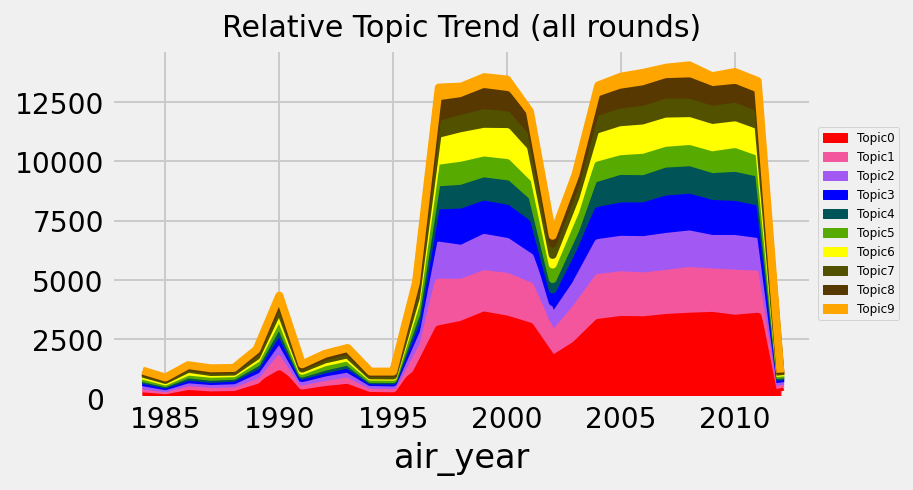

In [246]:
# plt.style.use('fivethirtyeight')
# ax = year_topic.plot.area(figsize=(7,3), cmap=cmap)

# # Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# # Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)
# plt.title("Relative Topic Trend (all rounds)", size =15)

# plt.show()

In [256]:
def myplot(df_document_topic, round_name):

    year_topic = df_document_topic.groupby(["air_year", "dominant_topic"]) \
            .count().reset_index() \
            .iloc[:, 0:3] \
            .rename(columns={"Topic0": "count"})

    year_topic = year_topic.pivot_table("count", ["air_year"], "dominant_topic").reset_index() \
                .set_index("air_year")

    year_topic.columns = ["Topic" + str(i) for i in year_topic.columns]

    cmap = colors.LinearSegmentedColormap.from_list("", ["red","violet","blue", "green", "yellow", "black", "orange"])
    ax = year_topic.plot(figsize=(7,3), cmap=cmap, lw=1)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)

    plt.title(f"Topic Trend {round_name}", size =15)
    #lightening the borderbound
    ax.spines["top"].set_alpha(.0)
    # ax.spines["right"].set_alpha(.0)
    # ax.spines["left"].set_alpha(.0)
    # ax.spines["bottom"].set_bounds(0, 59)
    # ax.spines["bottom"].set_linewidth(0.6)
    plt.show();

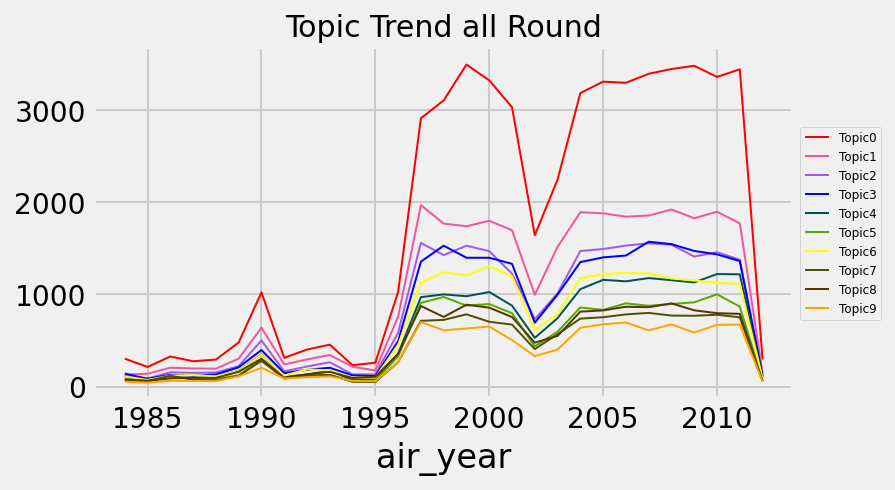

In [261]:
# myplot(df_document_topic=df_document_topic, round_name="all Round")

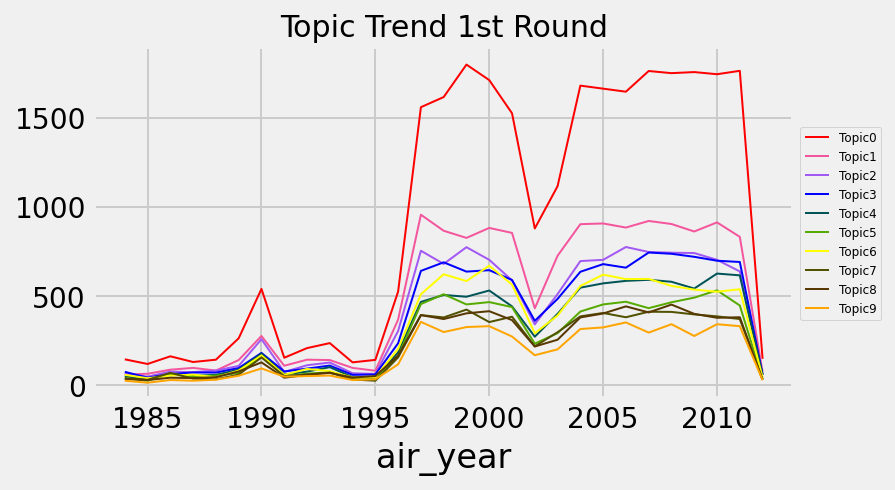

In [257]:
# myplot(df_document_topic=df_document_topic_sinle, round_name="1st Round")

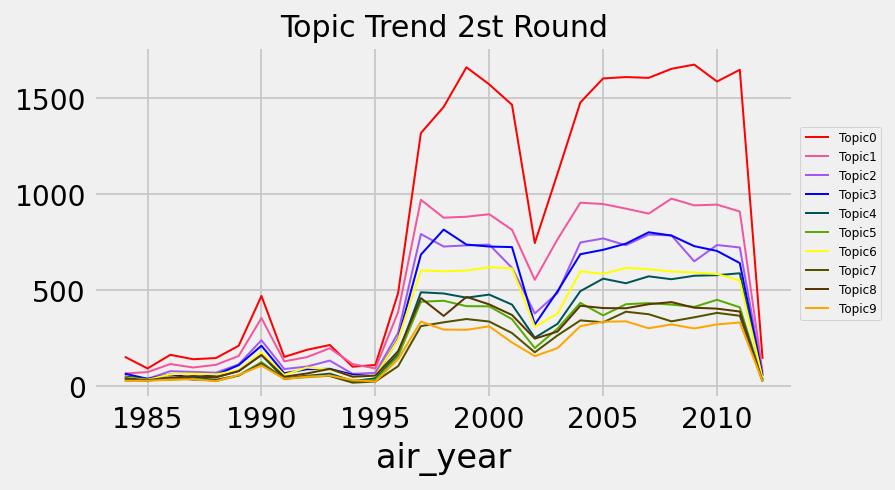

In [259]:
# myplot(df_document_topic=df_document_topic_double, round_name="2st Round")

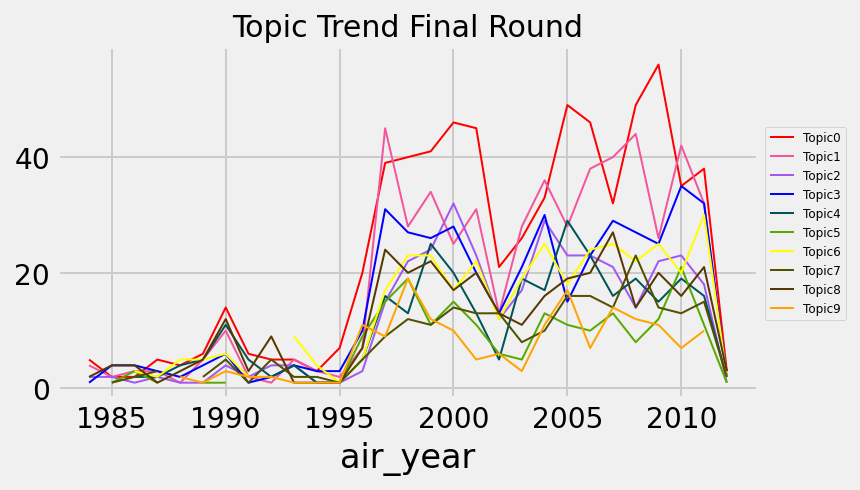

In [260]:
# myplot(df_document_topic=df_document_topic_final, round_name="Final Round")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e90ad0a1-8e10-4a4d-ac98-94f8e8b026dd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>